In [1]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU

import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav


/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/arc/fdp5/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
# print environment
folder_path = "../../data"
for l in os.listdir(folder_path):
    print(l)

fearful
savee
calm
happy
bdes
surprised
angry
sad
keywords


In [3]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [4]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [5]:
# This function prints metrics about a model
def print_metrics(voice_module, X, Y, label_name_list):
    Y_pred = voice_module.model._model.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_max = np.argmax(Y, axis=1)
    print(confusion_matrix(Y_max, Y_pred))
    print(classification_report(Y_max, Y_pred, target_names=label_name_list))


In [6]:
# Create class
class EmotionClassifierCnn(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        model.add(GaussianNoise(0.4))
        model.add(BatchNormalization())
        model.add(Conv1D(128, 3, input_shape=(35, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(64, 5, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(GaussianNoise(0.4))
        model.add(Dense(64))
        model.add(Dense(5))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=35, padding='post')[0]
        return to_process


In [7]:
#Instanciate model
emotion_list = ["calm", "happy", "angry", "fearful", "sad"]
dimension_mfcc = 13
samplerate = 16000
nb_break=None
sample_duration=1
step=0.5

logger = PerformanceLogger()

cls = EmotionClassifierCnn()
vm = VoiceModule("emotion-1s", emotion_list, cls)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done")

Doing calm
Doing happy
Doing angry
Doing fearful
Doing sad
Done


In [9]:
X_file = f"x_{'_'.join(emotion_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(emotion_list)}-{vm._name}.npy"

In [10]:
# Saving the prepared input data 
np.save(X_file, X)
np.save(Y_file, Y)


In [11]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)

In [12]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

4584 1147
(35, 13)
float32


In [13]:
vm.model.train(X_train, Y_train, batch_size=64, epoch=100, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 4584 samples, validate on 1147 samples
Epoch 1/100
4584/4584 [==============================] - 3s 729us/sample - loss: 1.9840 - acc: 0.3418 - val_loss: 2.4065 - val_acc: 0.2485
Epoch 2/100
4584/4584 [==============================] - 2s 383us/sample - loss: 1.3984 - acc: 0.4335 - val_loss: 1.5336 - val_acc: 0.3601
Epoch 3/100
4584/4584 [==============================] - 2s 420us/sample - loss: 1.2286 - acc: 0.5085 - val_loss: 1.3524 - val_acc: 0.4342
Epoch 4/100
4584/4584 [==============================] - 2s 410us/sample - loss: 1.1316 - acc: 0.5369 - val_loss: 1.1593 - val_acc: 0.5327
Epoch 5/100
4584/4584 [==============================] - 2s 364us/sample - loss: 1.0579 - acc: 0.5700 - val_loss: 1.1548 - val_acc: 0.5179
Epoch 6/100
4584/4584 [==============================] - 2s 398us/sample - loss: 1.0064 - acc: 0.5927 - val_loss: 1.0477 - val_acc: 0.5772
Epoch 7/100
4584/4584 [==============================] - 2s 378us/sample - loss: 0.9607 - acc: 0.6187 - val_loss: 1.02

4584/4584 [==============================] - 2s 360us/sample - loss: 0.2879 - acc: 0.8938 - val_loss: 0.6970 - val_acc: 0.7489
Epoch 60/100
4584/4584 [==============================] - 2s 369us/sample - loss: 0.2838 - acc: 0.8938 - val_loss: 0.6992 - val_acc: 0.7550
Epoch 61/100
4584/4584 [==============================] - 2s 392us/sample - loss: 0.2688 - acc: 0.8951 - val_loss: 0.7273 - val_acc: 0.7541
Epoch 62/100
4584/4584 [==============================] - 2s 354us/sample - loss: 0.3027 - acc: 0.8809 - val_loss: 0.7441 - val_acc: 0.7376
Epoch 63/100
4584/4584 [==============================] - 2s 361us/sample - loss: 0.2826 - acc: 0.8938 - val_loss: 0.7664 - val_acc: 0.7411
Epoch 64/100
4584/4584 [==============================] - 2s 389us/sample - loss: 0.3013 - acc: 0.8870 - val_loss: 0.6472 - val_acc: 0.7724
Epoch 65/100
4584/4584 [==============================] - 2s 356us/sample - loss: 0.2658 - acc: 0.8997 - val_loss: 0.6716 - val_acc: 0.7716
Epoch 66/100
4584/4584 [=========

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  52        
_________________________________________________________________
conv1d (Conv1D)              multiple                  5120      
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) multiple                  0         
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  41024     
_________________________________________________________________
activation_1 (Activation)    multiple                  0

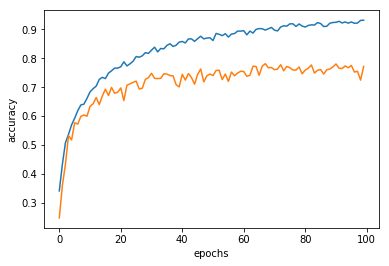

[[219   7   4   6  19]
 [ 16 152  18  18  12]
 [ 11  10 184  18  10]
 [ 11  12   9 164  16]
 [ 30  13  10  12 166]]
              precision    recall  f1-score   support

        calm       0.76      0.86      0.81       255
       happy       0.78      0.70      0.74       216
       angry       0.82      0.79      0.80       233
     fearful       0.75      0.77      0.76       212
         sad       0.74      0.72      0.73       231

    accuracy                           0.77      1147
   macro avg       0.77      0.77      0.77      1147
weighted avg       0.77      0.77      0.77      1147



In [14]:
vm.model._model.summary()


plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print_metrics(vm, X_test, Y_test, emotion_list)

In this graph we can see that the model largely overfit around the 20st epoch
We can also see that the testing data's accuracy continues to grow.

In [15]:
# Now we save the model so we don't have to retrain it each time
vm.model.save("emotion_cnn-1s.model")

In [19]:
# Here we load the model to check if nothing went wrong
vm.model.load("emotion_cnn-1s.model")

In [20]:
# Now we load the new dataset (savee)

# First we change the folder path
folder_path = "../../data/savee"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_savee, Y_savee = preprare_wav(data, vm, sample_duration, step)
X_savee = X_savee.astype('float32')
X_savee_train, X_savee_test, Y_savee_train, Y_savee_test = train_test_split(X_savee, Y_savee, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing sad


In [21]:
print(X_savee.shape)
vm.model._model.evaluate(X_savee, Y_savee)
print_metrics(vm, X_savee, Y_savee, emotion_list)

(1894, 35, 13)
1894/1894 [==============================] - 1s 407us/sample - loss: 7.6659 - acc: 0.2920
[[197  59  82   0  22]
 [ 73 157 108  12  18]
 [ 76 104 156  12  10]
 [ 95  99 126  21  17]
 [194 112 116   6  22]]
              precision    recall  f1-score   support

        calm       0.31      0.55      0.40       360
       happy       0.30      0.43      0.35       368
       angry       0.27      0.44      0.33       358
     fearful       0.41      0.06      0.10       358
         sad       0.25      0.05      0.08       450

    accuracy                           0.29      1894
   macro avg       0.31      0.30      0.25      1894
weighted avg       0.30      0.29      0.24      1894



In [22]:
# Now we freeze every layer used for extracting features from data
savee_model = keras.models.clone_model(vm.model._model)
for layer in savee_model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
savee_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
savee_cls = EmotionClassifierCnn()
savee_cls._model = savee_model
savee_vm = VoiceModule("emotion-1s", emotion_list, savee_cls)

gaussian_noise
batch_normalization
conv1d
activation
max_pooling1d
conv1d_1
activation_1
max_pooling1d_1
flatten
batch_normalization_1
dropout
gaussian_noise_1


In [23]:
# And we train the two last layers
# This is classic fine tuning
savee_vm.model.train(X_savee_train, Y_savee_train, batch_size=10, validation_data=(X_savee_test, Y_savee_test), epoch=100)

Train on 1515 samples, validate on 379 samples
Epoch 1/100
1515/1515 [==============================] - 3s 2ms/sample - loss: 2.1702 - acc: 0.3168 - val_loss: 94.7780 - val_acc: 0.1979
Epoch 2/100
1515/1515 [==============================] - 2s 998us/sample - loss: 1.5881 - acc: 0.4198 - val_loss: 74.2938 - val_acc: 0.1926
Epoch 3/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.4049 - acc: 0.4581 - val_loss: 106.4523 - val_acc: 0.1900
Epoch 4/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.3100 - acc: 0.4785 - val_loss: 94.2494 - val_acc: 0.1900
Epoch 5/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.2670 - acc: 0.4871 - val_loss: 96.5158 - val_acc: 0.1900
Epoch 6/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.2464 - acc: 0.4911 - val_loss: 92.4279 - val_acc: 0.1900
Epoch 7/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.2108 - acc: 0.5122 - val_loss: 112.2898 -

1515/1515 [==============================] - 2s 1ms/sample - loss: 1.0917 - acc: 0.5677 - val_loss: 91.4770 - val_acc: 0.1900
Epoch 60/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.1029 - acc: 0.5604 - val_loss: 77.9855 - val_acc: 0.1900
Epoch 61/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.1061 - acc: 0.5472 - val_loss: 84.5402 - val_acc: 0.1900
Epoch 62/100
1515/1515 [==============================] - 1s 982us/sample - loss: 1.1029 - acc: 0.5426 - val_loss: 95.3044 - val_acc: 0.1900
Epoch 63/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.0979 - acc: 0.5657 - val_loss: 71.5488 - val_acc: 0.1900
Epoch 64/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.0788 - acc: 0.5670 - val_loss: 106.4081 - val_acc: 0.1900
Epoch 65/100
1515/1515 [==============================] - 2s 1ms/sample - loss: 1.0704 - acc: 0.5604 - val_loss: 88.6138 - val_acc: 0.1900
Epoch 66/100
1515/1515 [=============

In [24]:
print_metrics(savee_vm, X_savee_test, Y_savee_test, emotion_list)

[[72  0  0  0  0]
 [78  0  0  0  0]
 [65  0  0  0  0]
 [72  0  0  0  0]
 [92  0  0  0  0]]
              precision    recall  f1-score   support

        calm       0.19      1.00      0.32        72
       happy       0.00      0.00      0.00        78
       angry       0.00      0.00      0.00        65
     fearful       0.00      0.00      0.00        72
         sad       0.00      0.00      0.00        92

    accuracy                           0.19       379
   macro avg       0.04      0.20      0.06       379
weighted avg       0.04      0.19      0.06       379



/home/arc/fdp5/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Now we load the new dataset (savee)

# First we change the folder path
folder_path = "../../data/bdes"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_bdes, Y_bdes = preprare_wav(data, vm, sample_duration, step)
X_bdes = X_bdes.astype('float32')
X_bdes_train, X_bdes_test, Y_bdes_train, Y_bdes_test = train_test_split(X_bdes, Y_bdes, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing sad


In [26]:
print(X_bdes.shape)
vm.model._model.evaluate(X_bdes, Y_bdes)
print_metrics(vm, X_bdes, Y_bdes, emotion_list)

(1448, 35, 13)
1448/1448 [==============================] - 0s 226us/sample - loss: 6.4236 - acc: 0.2459
[[ 14  41 190  11   2]
 [  1  31 186  37   2]
 [  2  22 261  35   0]
 [  2  15 141  50   0]
 [ 45  45 131 184   0]]
              precision    recall  f1-score   support

        calm       0.22      0.05      0.09       258
       happy       0.20      0.12      0.15       257
       angry       0.29      0.82      0.42       320
     fearful       0.16      0.24      0.19       208
         sad       0.00      0.00      0.00       405

    accuracy                           0.25      1448
   macro avg       0.17      0.25      0.17      1448
weighted avg       0.16      0.25      0.16      1448



In [27]:
# Now we freeze every layer used for extracting features from data
bdes_model = keras.models.clone_model(vm.model._model)
for layer in bdes_model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
bdes_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bdes_cls = EmotionClassifierCnn()
bdes_cls._model = bdes_model
bdes_vm = VoiceModule("emotion-1s", emotion_list, bdes_cls)

gaussian_noise
batch_normalization
conv1d
activation
max_pooling1d
conv1d_1
activation_1
max_pooling1d_1
flatten
batch_normalization_1
dropout
gaussian_noise_1


In [28]:
# And we train the two last layers
# This is classic fine tuning
bdes_vm.model.train(X_bdes_train, Y_bdes_train, batch_size=10, validation_data=(X_bdes_test, Y_bdes_test), epoch=100)

Train on 1158 samples, validate on 290 samples
Epoch 1/100
1158/1158 [==============================] - 2s 2ms/sample - loss: 1.6845 - acc: 0.4845 - val_loss: 59.5957 - val_acc: 0.3414
Epoch 2/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 1.1592 - acc: 0.6054 - val_loss: 64.9340 - val_acc: 0.2724
Epoch 3/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 1.0099 - acc: 0.6416 - val_loss: 83.3389 - val_acc: 0.2586
Epoch 4/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 0.9135 - acc: 0.6623 - val_loss: 80.1418 - val_acc: 0.2759
Epoch 5/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 0.9667 - acc: 0.6485 - val_loss: 65.3132 - val_acc: 0.2759
Epoch 6/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 0.8741 - acc: 0.6649 - val_loss: 82.1915 - val_acc: 0.2586
Epoch 7/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 0.8403 - acc: 0.6710 - val_loss: 83.8893 - val

1158/1158 [==============================] - 1s 1ms/sample - loss: 0.6818 - acc: 0.7107 - val_loss: 75.7383 - val_acc: 0.3207
Epoch 60/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 0.7156 - acc: 0.7142 - val_loss: 81.9980 - val_acc: 0.3414
Epoch 61/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 0.6323 - acc: 0.7547 - val_loss: 90.7898 - val_acc: 0.3310
Epoch 62/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 0.6961 - acc: 0.7107 - val_loss: 84.0374 - val_acc: 0.3448
Epoch 63/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 0.7109 - acc: 0.7193 - val_loss: 78.6729 - val_acc: 0.2759
Epoch 64/100
1158/1158 [==============================] - 1s 986us/sample - loss: 0.6629 - acc: 0.7271 - val_loss: 72.3993 - val_acc: 0.3517
Epoch 65/100
1158/1158 [==============================] - 1s 1ms/sample - loss: 0.6720 - acc: 0.7340 - val_loss: 68.4743 - val_acc: 0.3483
Epoch 66/100
1158/1158 [==============

In [29]:
print_metrics(bdes_vm, X_bdes_test, Y_bdes_test, emotion_list)

[[43  0  3  0  0]
 [11  0 41  0  0]
 [ 3  1 56  0  0]
 [27  1 23  0  0]
 [66  0 15  0  0]]
              precision    recall  f1-score   support

        calm       0.29      0.93      0.44        46
       happy       0.00      0.00      0.00        52
       angry       0.41      0.93      0.57        60
     fearful       0.00      0.00      0.00        51
         sad       0.00      0.00      0.00        81

    accuracy                           0.34       290
   macro avg       0.14      0.37      0.20       290
weighted avg       0.13      0.34      0.19       290



/home/arc/fdp5/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
